In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import tensorflow as tf
tf.__version__

'2.17.1'

In [ ]:
import os
import cv2
import numpy as np

# Function to load and preprocess images from a given directory
def load_images_in_batches(directory, batch_size=100):
    all_images = []
    all_labels = []

    class_names = os.listdir(directory)
    class_names.sort()  # Sort classes for consistent labeling

    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            image_files = os.listdir(class_dir)
            for i in range(0, len(image_files), batch_size):
                batch_files = image_files[i:i + batch_size]
                for filename in batch_files:
                    image_path = os.path.join(class_dir, filename)
                    image = cv2.imread(image_path)
                    if image is not None:
                        # Convert from BGR to Grayscale directly
                        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        equalized_image = cv2.equalizeHist(gray_image)
                        resized_image = cv2.resize(equalized_image, (32, 32))
                        all_images.append(resized_image)
                        all_labels.append(class_index)

    return np.array(all_images), np.array(all_labels)

# Specify the correct directory paths
train_directory = "/content/drive/MyDrive/train80%"  # Replace with the correct path for training data
val_directory = "/content/drive/MyDrive/validation20%"  # Replace with the correct path for validation data
test_directory = "/content/drive/MyDrive/test20%"  # Replace with the correct path for test data

# Load images from all directories (train, validation, and test)
X_train, y_train = load_images_in_batches(train_directory)
X_val, y_val = load_images_in_batches(val_directory)
X_test, y_test = load_images_in_batches(test_directory)

# Print the shapes to confirm the data loading
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (4400, 32, 32)
Shape of y_train: (4400,)
Shape of X_val: (1460, 32, 32)
Shape of y_val: (1460,)
Shape of X_test: (1604, 32, 32)
Shape of y_test: (1604,)


In [ ]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f"Classes: {unique_classes}")
print(f"Class counts: {class_counts}")

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Class counts: [ 102  216  576 1038  160  116  720  246  288  188  634  116]


In [ ]:
class_names = os.listdir(train_directory)
class_names.sort()
print(f"Class names: {class_names}")

Class names: ['Bend to left', 'Bend to right', 'Danger', 'Give way', 'Left zigzag bend', 'No overtaking', 'Road work', 'Slippery road', 'Traffic Signal Ahead', 'Uneven road', 'crossroads ahead', 'pedestrian crossing']


In [ ]:
for class_name in class_names:
    class_dir = os.path.join(train_directory, class_name)
    if os.path.isdir(class_dir):
        print(f"{class_name}: {len(os.listdir(class_dir))} images")

Bend to left: 102 images
Bend to right: 216 images
Danger: 576 images
Give way: 1038 images
Left zigzag bend: 160 images
No overtaking: 116 images
Road work: 720 images
Slippery road: 246 images
Traffic Signal Ahead: 288 images
Uneven road: 188 images
crossroads ahead: 634 images
pedestrian crossing: 116 images


In [ ]:
# Load and preprocess data from train, validation, and test directories
X_train, y_train = load_images_in_batches(train_directory)
X_val, y_val = load_images_in_batches(val_directory)
X_test, y_test = load_images_in_batches(test_directory)

# Reshape data to add a channel dimension (LeNet-5 expects 4D input: (samples, height, width, channels))
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Print new shapes to confirm
print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of X_val after reshaping: {X_val.shape}")
print(f"Shape of X_test after reshaping: {X_test.shape}")


Shape of X_train after reshaping: (4400, 32, 32, 1)
Shape of X_val after reshaping: (1460, 32, 32, 1)
Shape of X_test after reshaping: (1604, 32, 32, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=12)
y_val = to_categorical(y_val, num_classes=12)
y_test = to_categorical(y_test, num_classes=12)

# Print label shapes to confirm
print(f"Shape of y_train after encoding: {y_train.shape}")
print(f"Shape of y_val after encoding: {y_val.shape}")
print(f"Shape of y_test after encoding: {y_test.shape}")

Shape of y_train after encoding: (4400, 12)
Shape of y_val after encoding: (1460, 12)
Shape of y_test after encoding: (1604, 12)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Initialize the model
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32, 32, 1)))

# Layer 2: Average Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))

# Layer 4: Average Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2)))

# Layer 5: Flatten Layer
model.add(Flatten())

# Layer 6: Fully Connected Layer
model.add(Dense(120, activation='tanh'))

# Layer 7: Fully Connected Layer
model.add(Dense(84, activation='tanh'))

# Layer 8: Output Layer
model.add(Dense(12, activation='softmax'))

# Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │           1,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,876 (241.70 KB)

 Trainable params: 61,876 (241.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,  # Adjust epochs as needed
                    batch_size=32)  # Adjust batch size if required

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5128 - loss: 1.6220 - val_accuracy: 0.8801 - val_loss: 0.4370
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8901 - loss: 0.3826 - val_accuracy: 0.9137 - val_loss: 0.2955
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9312 - loss: 0.2472 - val_accuracy: 0.9301 - val_loss: 0.2228
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9535 - loss: 0.1699 - val_accuracy: 0.9500 - val_loss: 0.1822
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9737 - loss: 0.1178 - val_accuracy: 0.9521 - val_loss: 0.1627
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9782 - loss: 0.0925 - val_accuracy: 0.9562 - val_loss: 0.1580
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9845 - loss: 0.0722 - val_accuracy: 0.9671 - val_loss: 0.1366
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9872 - loss: 0.0567 - val_accu

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9742 - loss: 0.1219
Test Accuracy: 0.9794
Test Loss: 0.0926


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


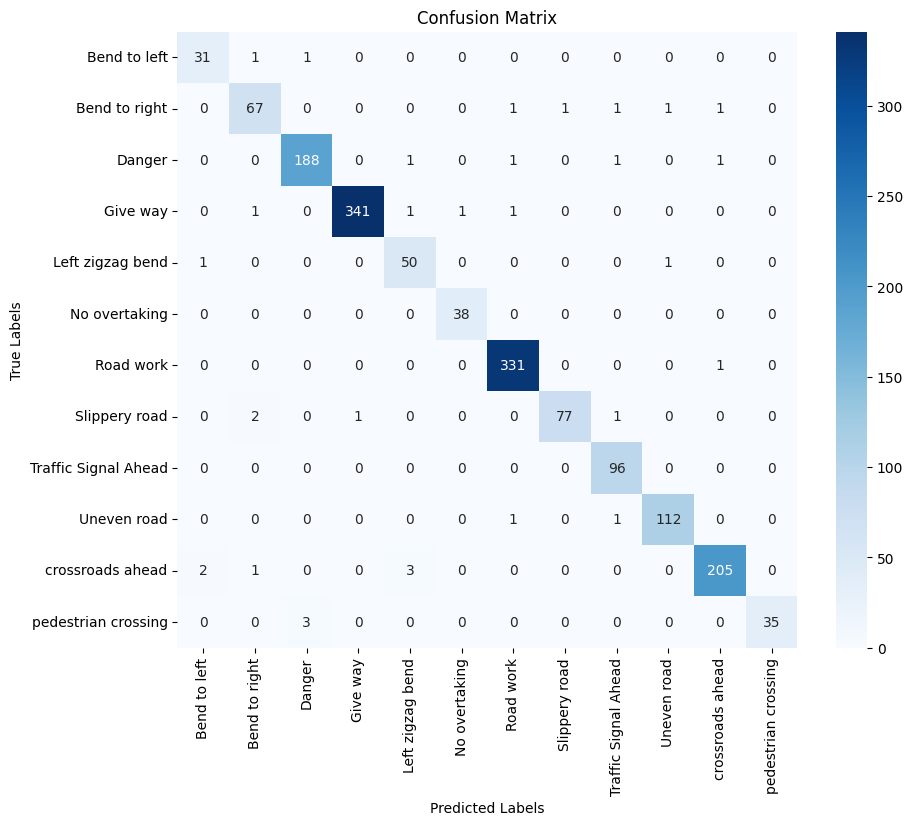

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get the true labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels back to class labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import tensorflow as tf
tf.__version__

'2.17.1'

In [ ]:
import os
import cv2
import numpy as np

# Function to load and preprocess images from a given directory
def load_images_in_batches(directory, batch_size=100):
    all_images = []
    all_labels = []

    class_names = os.listdir(directory)
    class_names.sort()  # Sort classes for consistent labeling

    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            image_files = os.listdir(class_dir)
            for i in range(0, len(image_files), batch_size):
                batch_files = image_files[i:i + batch_size]
                for filename in batch_files:
                    image_path = os.path.join(class_dir, filename)
                    image = cv2.imread(image_path)
                    if image is not None:
                        # Convert from BGR to Grayscale directly
                        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        equalized_image = cv2.equalizeHist(gray_image)
                        resized_image = cv2.resize(equalized_image, (32, 32))
                        all_images.append(resized_image)
                        all_labels.append(class_index)

    return np.array(all_images), np.array(all_labels)

# Specify the correct directory paths
train_directory = "/content/drive/MyDrive/train80%"  # Replace with the correct path for training data
val_directory = "/content/drive/MyDrive/Renamed_validation20%"  # Replace with the correct path for validation data
test_directory = "/content/drive/MyDrive/Renamed_test20%"  # Replace with the correct path for test data

# Load images from all directories (train, validation, and test)
X_train, y_train = load_images_in_batches(train_directory)
X_val, y_val = load_images_in_batches(val_directory)
X_test, y_test = load_images_in_batches(test_directory)

# Print the shapes to confirm the data loading
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4400, 32, 32)
Shape of y_train: (4400,)
Shape of X_val: (1460, 32, 32)
Shape of y_val: (1460,)
Shape of X_test: (1604, 32, 32)
Shape of y_test: (1604,)


In [ ]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f"Classes: {unique_classes}")
print(f"Class counts: {class_counts}")

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Class counts: [ 102  216  576 1038  160  116  720  246  288  188  634  116]


In [ ]:
class_names = os.listdir(train_directory)
class_names.sort()
print(f"Class names: {class_names}")

Class names: ['Bend to left', 'Bend to right', 'Danger', 'Give way', 'Left zigzag bend', 'No overtaking', 'Road work', 'Slippery road', 'Traffic Signal Ahead', 'Uneven road', 'crossroads ahead', 'pedestrian crossing']


In [ ]:
for class_name in class_names:
    class_dir = os.path.join(train_directory, class_name)
    if os.path.isdir(class_dir):
        print(f"{class_name}: {len(os.listdir(class_dir))} images")

Bend to left: 102 images
Bend to right: 216 images
Danger: 576 images
Give way: 1038 images
Left zigzag bend: 160 images
No overtaking: 116 images
Road work: 720 images
Slippery road: 246 images
Traffic Signal Ahead: 288 images
Uneven road: 188 images
crossroads ahead: 634 images
pedestrian crossing: 116 images


In [ ]:
# Load and preprocess data from train, validation, and test directories
X_train, y_train = load_images_in_batches(train_directory)
X_val, y_val = load_images_in_batches(val_directory)
X_test, y_test = load_images_in_batches(test_directory)

# Reshape data to add a channel dimension (LeNet-5 expects 4D input: (samples, height, width, channels))
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Print new shapes to confirm
print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of X_val after reshaping: {X_val.shape}")
print(f"Shape of X_test after reshaping: {X_test.shape}")

Shape of X_train after reshaping: (4400, 32, 32, 1)
Shape of X_val after reshaping: (1460, 32, 32, 1)
Shape of X_test after reshaping: (1604, 32, 32, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=12)
y_val = to_categorical(y_val, num_classes=12)
y_test = to_categorical(y_test, num_classes=12)

# Print label shapes to confirm
print(f"Shape of y_train after encoding: {y_train.shape}")
print(f"Shape of y_val after encoding: {y_val.shape}")
print(f"Shape of y_test after encoding: {y_test.shape}")

Shape of y_train after encoding: (4400, 12)
Shape of y_val after encoding: (1460, 12)
Shape of y_test after encoding: (1604, 12)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Initialize the model
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32, 32, 1)))

# Layer 2: Average Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))

# Layer 4: Average Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2)))

# Layer 5: Flatten Layer
model.add(Flatten())

# Layer 6: Fully Connected Layer
model.add(Dense(120, activation='tanh'))

# Layer 7: Fully Connected Layer
model.add(Dense(84, activation='tanh'))

# Layer 8: Output Layer
model.add(Dense(12, activation='softmax'))

# Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │           1,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,876 (241.70 KB)

 Trainable params: 61,876 (241.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,  # Adjust epochs as needed
                    batch_size=32)  # Adjust batch size if required

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4815 - loss: 1.6817 - val_accuracy: 0.8699 - val_loss: 0.4482
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8756 - loss: 0.4092 - val_accuracy: 0.9096 - val_loss: 0.2973
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9395 - loss: 0.2334 - val_accuracy: 0.9459 - val_loss: 0.2042
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9626 - loss: 0.1477 - val_accuracy: 0.9459 - val_loss: 0.1878
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9684 - loss: 0.1253 - val_accuracy: 0.9623 - val_loss: 0.1634
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9741 - loss: 0.0949 - val_accuracy: 0.9616 - val_loss: 0.1350
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9893 - loss: 0.0563 - val_accuracy: 0.9685 - val_loss: 0.1217
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9864 - loss: 0.0634 - val_accuracy: 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9679 - loss: 0.1211
Test Accuracy: 0.9751
Test Loss: 0.0898


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


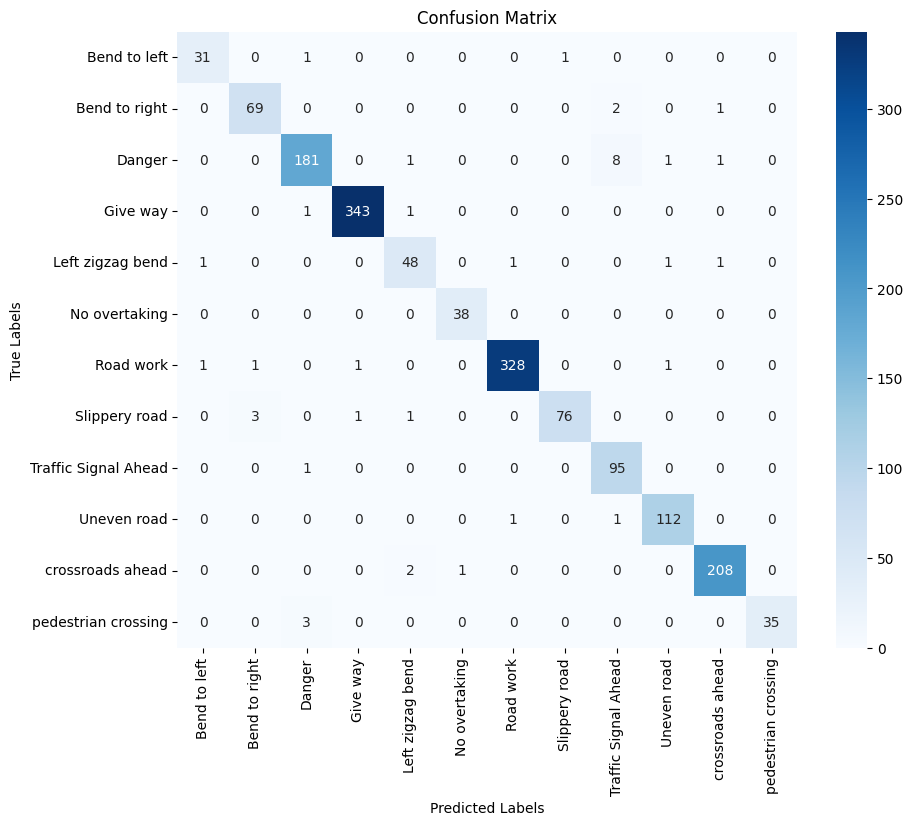

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get the true labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels back to class labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()